# Star Sky Simulation

1. [Generate the field](#i-part-generate-the-field)
    1. [First Cell](#first-cell)
    2. [Second and Third Cell](#second-and-third-cells)
    3. [Fourth Cell](#fourth-cell)
    4. [Fifth Cell](#fifth-cell)

---

## I part: generate the field

### First cell

I defined the parameters like the dimension of the field, the number of stars, the exponents of the potential laws and the IMF function

In [37]:
# FIRST CELL
##* packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from numpy.random import randint
from numba import jit
import os


# dimension of the matrix
N = int(1e2+1)
# number of stars
M = int(1e1)

## Set parameters
alpha = 2
beta  = 3
# minimum and maximum masses 
m_min = 0.1; m_max = 20
# Initial Mass Function
IMF = lambda m : m**(-alpha)
# def IMF(m):
#     if(m >= 0.01 and m < 0.08):
#         a = -0.3
#     elif(m >= 0.08 and m < 0.5 ):
#         a = -1.3
#     else:
#         a = -2.3
#     return m**a
IMF_min = IMF(0.1); IMF_max = IMF(20) 

print(f'IMF for smallest and biggest stars:\nM\t\tIMF\n0.1 Msun\t{IMF_min}\n20  Msun\t{IMF_max}')


IMF for smallest and biggest stars:
M		IMF
0.1 Msun	99.99999999999999
20  Msun	0.0025


### Second and Third cells
I defined the function for the random generation of the masses and then I created the luminosity array

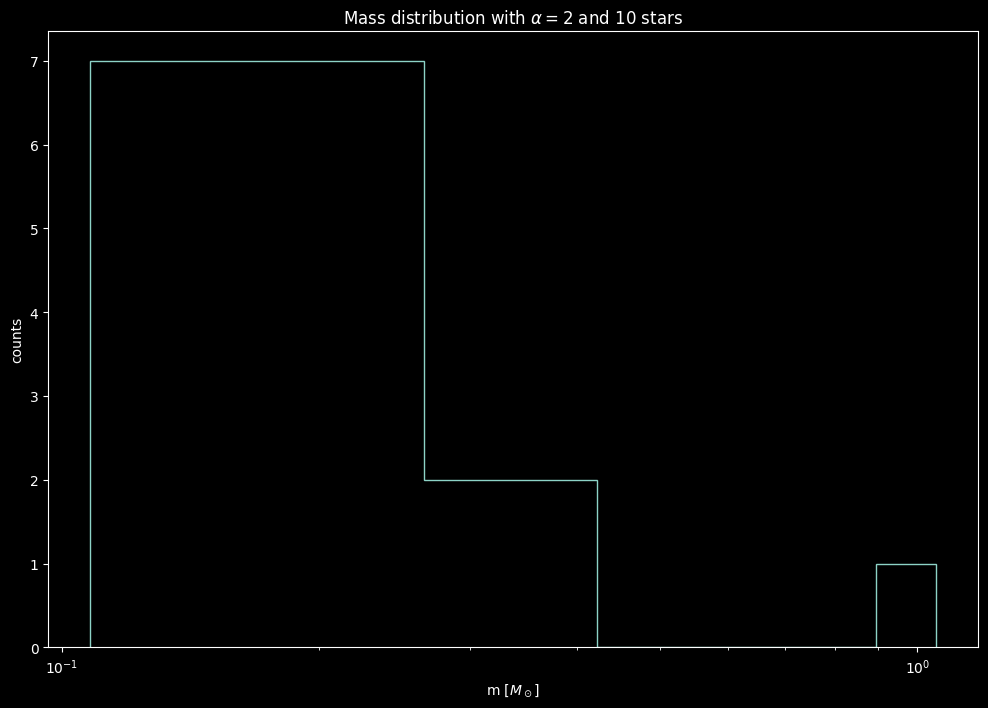

In [2]:
# SECOND CELL

# Current directory
pwd = os.getcwd()

##* 
def generate_mass_array(imf_min: float ,imf_max: float ,sdim: int = M) -> np.ndarray:
    """Genration of masses array with IMF distribution
    The function takes the minimum and the maximum of the
    IMF, generates a M-dimension array of random value for imf in
    [IMF_min,IMF_max] and returns a M-dimension array of masses,
    distribuited like the IMF

    :param imf_min: minimum imf value
    :type imf_min: float
    :param imf_max: maximum imf value
    :type imf_max: float
    :param sdim: number of stars, defaults to M
    :type sdim: int, optional

    :return: {dim} array of masses distributed like imf
    :rtype: np.ndarray
    """
    np.random.seed()
    return (np.random.rand(sdim)*(imf_min-imf_max)+imf_max)**(-1/alpha)
    # imf_trs = IMF(0.5)
    #dim = int(sdim/2)
    # imf1 = np.random.rand(dim)*(imf_trs-imf_max)+imf_max
    # imf1 = imf1**(-1/2)
    # imf2 = np.random.rand(dim)*(imf_min-imf_trs)+imf_min
    # imf2 = imf2**(-1/2)
#    return np.append(imf1,imf2)

# M array of masses in solar mass unit
m = generate_mass_array(IMF_min,IMF_max)

## Plot data

plt.figure(figsize=(12,8))
plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.hist(m,int(3*M/5),histtype='step')
plt.xscale('log')
#plt.xlim(0.09,20)
plt.xlabel('m [$M_\odot$]')
plt.ylabel('counts')


plt.show()



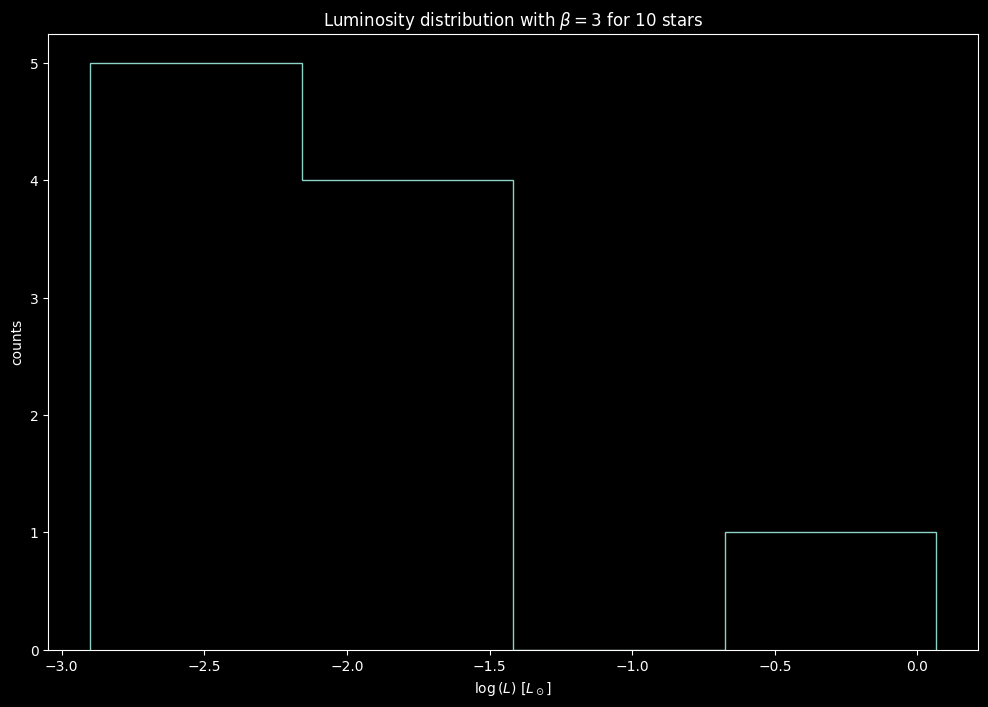

In [3]:
# THIRD CELL
# M array of luminosities in solar luminosity unit
L = m**beta

## Plot data
plt.figure(figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.hist(np.log10(L),int(2*M/5),histtype='step')
#plt.xlim(np.log10(0.09)*beta,np.log10(20)*beta)
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')

plt.show()

### Fourth cell
I defined the star class object, a class that contains all infos about star (mass,lum and position) and I implemented the function to set stars positions and the function to update the field matrix with the stars luminosities in mag. 
Since the function `plt.imshow()` takes float values from 0 to 1 to generate an image in grayscale, I decided to write the `transfer_function()`, that transforms luminosities into values in [0,1].

In [38]:
# FOURTH CELL
##* Star class obj to collect star informations
class star():
    """_summary_

    :param mass: _description_
    :type mass: float
    :param lum: _description_
    :type lum: float
    :param x: _description_
    :type x: float
    :param y: _description_
    :type y: float
    """
    def __init__(self, mass: float, lum: float, x: float ,y: float):
        self.m   = mass        # star mass value
        self.lum = lum        # star luminosity value
        self.x = x        # star x coordinate
        self.y = y        # star y coordinate

##* 
#? I have to check this function: the condition replace=False forbids M > N  
def star_location(sdim: int = M, dim: int = N) -> tuple:
    """Function to locate the stars
    It generates 2 random arrays of dimension n: 
    one is the x coordinate array and 
    y coordinate array of each star

    :param sdim: number of stars, defaults to M
    :type sdim: int, optional
    :param dim: dimension of the field, defaults to N
    :type dim: int, optional

    :return: tuple of star coordinates arrays
    :rtype: tuple
    """
    grid = [(i,j) for i in range(dim) for j in range(dim)]
    ind = np.random.choice(len(grid), size=M, replace=False)
    X = np.array([grid[i][0] for i in ind])
    Y = np.array([grid[i][1] for i in ind])
    return X, Y    




##* 
def update_field(F: np.ndarray, pos: tuple, lum: np.ndarray) -> np.ndarray:
    """Function to update the field
    It adds the generated stars to the field
    The shape of the field matrix is discussed
    in the next cell

    :param F: field matrix (dim,dim)
    :type F: np.ndarray
    :param pos: tuple of star coordinates arrays
    :type pos: tuple
    :param lum: luminosity array
    :type lum: np.ndarray

    :return: updated field matrix (dim,dim)
    :rtype: np.ndarray
    """
    X, Y = pos
    F[X,Y] += lum
    return F


##*   
def field_image(fig, image, F: np.ndarray, v: int = 0, sct: tuple = (0,-1)) -> None:
    """Function to represent the field
    It shows the field. It is possible to selected
    a section of the field using the parameter sct 

    :param image: matplotlib object
    :type image: Any
    :param F: field matrix
    :type F: np.ndarray
    :param v: set the color of the image, defaults to 0.
            *  1 for viridis
            *  0 for grayscale
            * -1 for inverse grayscale
    :type v: int, optional
    :param sct: selected square section of the field, defaults to [0,-1]
    :type sct: tuple, optional
    """
    a,b = sct
    # choose visualization
    if v == 0: color = 'gray'
    elif v == 1: color = 'viridis' 
    else: color = 'gray_r' 
    # image
    pic = image.imshow(F[a:b,a:b], cmap=color, norm='log')
    fig.colorbar(pic, ax=image, cmap=color, norm='log', location='bottom')

##* Transfer function
#?  Understand if it is reasonable 
'''   
    The implementation of this function is my choice. The function plt.imshow() takes float values in [0,1] to make grayscale image.
    I decided to convert luminosities into values in [0,1], using logaritmic values of them: 
        - I set a minimum detectable value of luminosity (called inf)
          Luminosities < inf are represented as black pixels
        - I normaled with the maximum value of luminosity (called sup)
          Luminosities = sup are converted in 1 (namely white)
'''
#   It converts luminosities in a scale from 0 to 1 to get grayscale
#   with function plt.imshow()
#     param    l    array of luminosities
# 
#     return    mag    converted magnitudes array   
# def transfer_function(l):
#     inf = 9e-5    # threshold to detect luminosity
#     sup = 8000    # maximum luminosity
#     # control the presence of 0s, change them with inf and save in an other temporary array
#     tmp = np.where(l<=0,inf,l)
#     # convertion
#     mag = (np.log10(tmp)-np.log10(inf)) / (np.log10(sup)-np.log10(inf))
#     # control the presence of negative values in mag and change them with 0
#     mag = np.where(mag<0,0,mag); mag = np.where(mag>1,1,mag)
#     return mag


    

'   \n    The implementation of this function is my choice. The function plt.imshow() takes float values in [0,1] to make grayscale image.\n    I decided to convert luminosities into values in [0,1], using logaritmic values of them: \n        - I set a minimum detectable value of luminosity (called inf)\n          Luminosities < inf are represented as black pixels\n        - I normaled with the maximum value of luminosity (called sup)\n          Luminosities = sup are converted in 1 (namely white)\n'

### Fifth cell
I implemented the initialization function to generate the masses, the field and the image without any psf or noise.

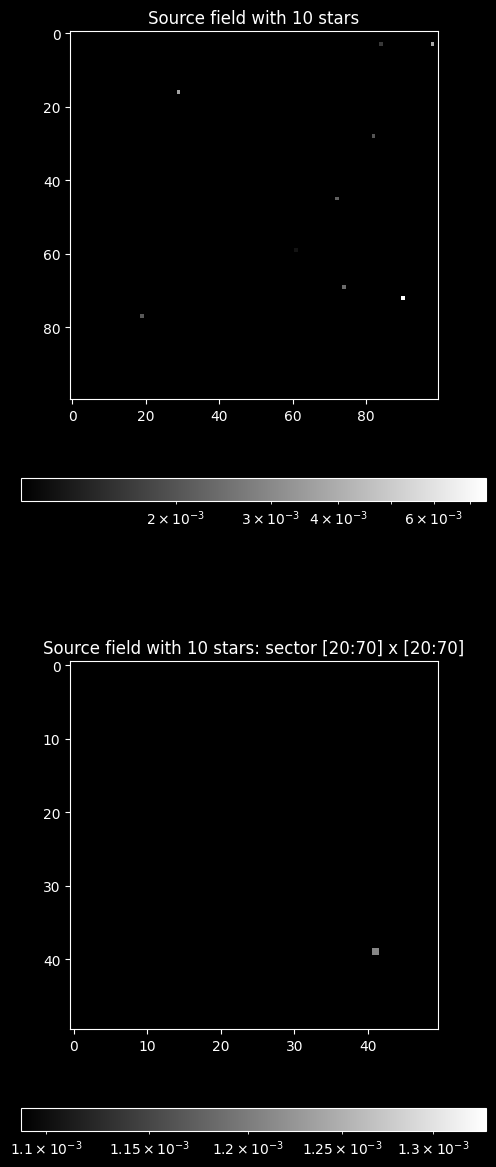

In [39]:
# FIFTH CELL

def check_field(field: np.ndarray) -> np.ndarray:
    """Check the presence of negative values
    The function finds possible negative values
    and substitutes them with 0.0

    :param field: field matrix
    :type field: ndarray

    :return: checked field matrix
    :rtype: ndarray
    """
    return np.where(field < 0, 0.0, field)


##*
def initialize(dim: int = N, sdim: int = M) -> tuple:
    """Initialization function: generation of the "perfect" sky
    It generates the stars and initialized the field to make
    the sky image without any psf and noise

    :param dim: dimension of the field, defaults to N
    :type dim: int, optional
    :param sdim: number of stars, defaults to M
    :type sdim: int, optional
    :return: tuple of the field matrix F and :class: `star` object with all the informations
    :rtype: tuple
    """
    # generate a (dim,dim) matrix of 0s
    F = np.zeros([dim,dim])
    # generate masses
    m = generate_mass_array(IMF_min, IMF_max, sdim=sdim)
    # set luminosities
    L = m**beta
    # generate stars coordinates
    xs,ys = star_location(sdim, dim=dim)
    # put stars in the field
    F = check_field(update_field(F,(xs,ys),L))
    # save stars infos
    S = star(m,L,xs,ys)
    return F, S

# generation of the field and the stars
F, S = initialize()

## Plot
# variables to zoom a sector [inf:sup] x [inf:sup] of the field
inf = int(0.2*N)
sup = int(0.7*N)

fig, axs = plt.subplots(2, 1, figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = 0

img_field, img_zoom = axs

field_image(fig, img_field,F,v)
#img_field.imshow(1-F)
img_field.set_title(f'Source field with {M} stars')
field_image(fig, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'Source field with {M} stars: sector [{inf}:{sup}] x [{inf}:{sup}]')

plt.show()

### Sixth cell
I implemented the function for the atmosferic seeing by gaussian distribution

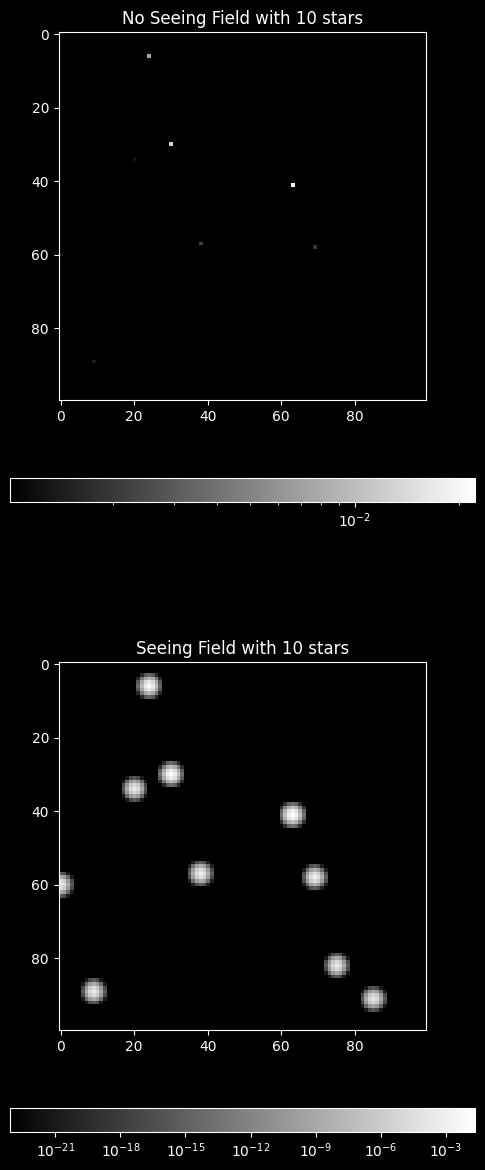

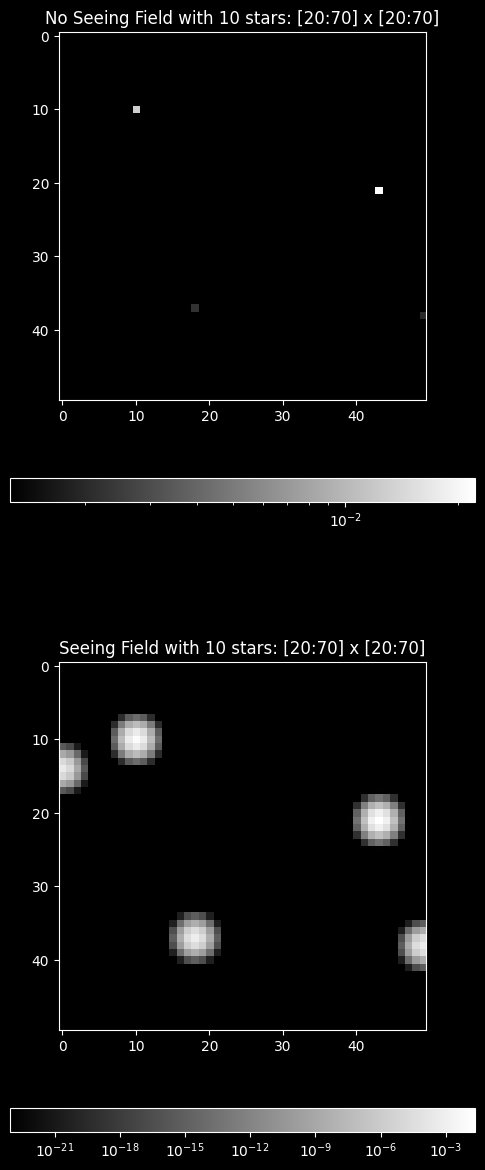

In [40]:
# SIXTH CELL
##* 
def gaussian(sigma: float = 0.3, dim: int = N) -> np.ndarray:
    """Gaussian matrix generator
    It makes a gaussian [dim,dim] matrix, centered in (0,0)

    :param sigma: the root of variance, defaults to 0.5
    :type sigma: float, optional
    :param dim: size of the field, defaults to N
    :type dim: int, optional
    
    :return: gaussian [dim,dim] matrix
    :rtype: np.ndarray
    """
    x = np.arange(dim, dtype=int)
    y = np.arange(dim, dtype=int)
    # shift to center of the field
    x -= int(dim/2);  y -= int(dim/2)
    # Gaussian function
    G = lambda r : np.exp(-r**2/sigma**2/2)
    # generate [dim,dim] matrix = G_i * G_j
    return np.outer(G(x),G(y))


##* 
#?  Add a parameter to choose atm pfs between Gaussian and Lorentzian
def atm_seeing(f: np.ndarray, sigma: float = 0.5) -> np.ndarray:
    """Atmosferic seeing function
    It convolves the field with tha Gaussian to
    make the atmosferic seeing

    :param f: field matrix
    :type f: np.ndarray
    :param sigma: the root of variance of Gaussian, defaults to 0.5
    :type sigma: float, optional
    
    :return: field matrix with seeing
    :rtype: np.ndarray
    """
    # dim of the field
    n = len(f)
    # call f_s the new field with seeing
#    f_s = f
    # take [n,n] matrix from the field
    field = f
    # convolution with gaussian
    field = fftconvolve(field, gaussian(sigma=sigma, dim=n), mode='same')
    # values are saved in each color channel 
    # to have grayscale
    return check_field(field)

# generation of the field and the stars
F, S = initialize()

## Plot
fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, (img_zoom, img_zoom_seeing)   = plt.subplots(2,1,figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = 0

field_image(fig1, img_field,F,v)
#img_field.imshow(1-F)
img_field.set_title(f'No Seeing Field with {M} stars')
field_image(fig1, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'No Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

# generation of the seeing image
F_s = atm_seeing(F)
field_image(fig2, img_field_seeing,F_s,v)
#img_field_seeing.imshow(1-F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
#img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

# path for images directory
picdir = os.path.join(pwd,'Pictures')

# par to save figures
#   1   save
#   0   not
sv = 0

if sv == 1:
    fig1.savefig(os.path.join(picdir,'field.png'))
    fig2.savefig(os.path.join(picdir,'zoom.png'))

plt.show()
    
    

### Seventh cell
I implemented function to add noise, both background and detector noise.

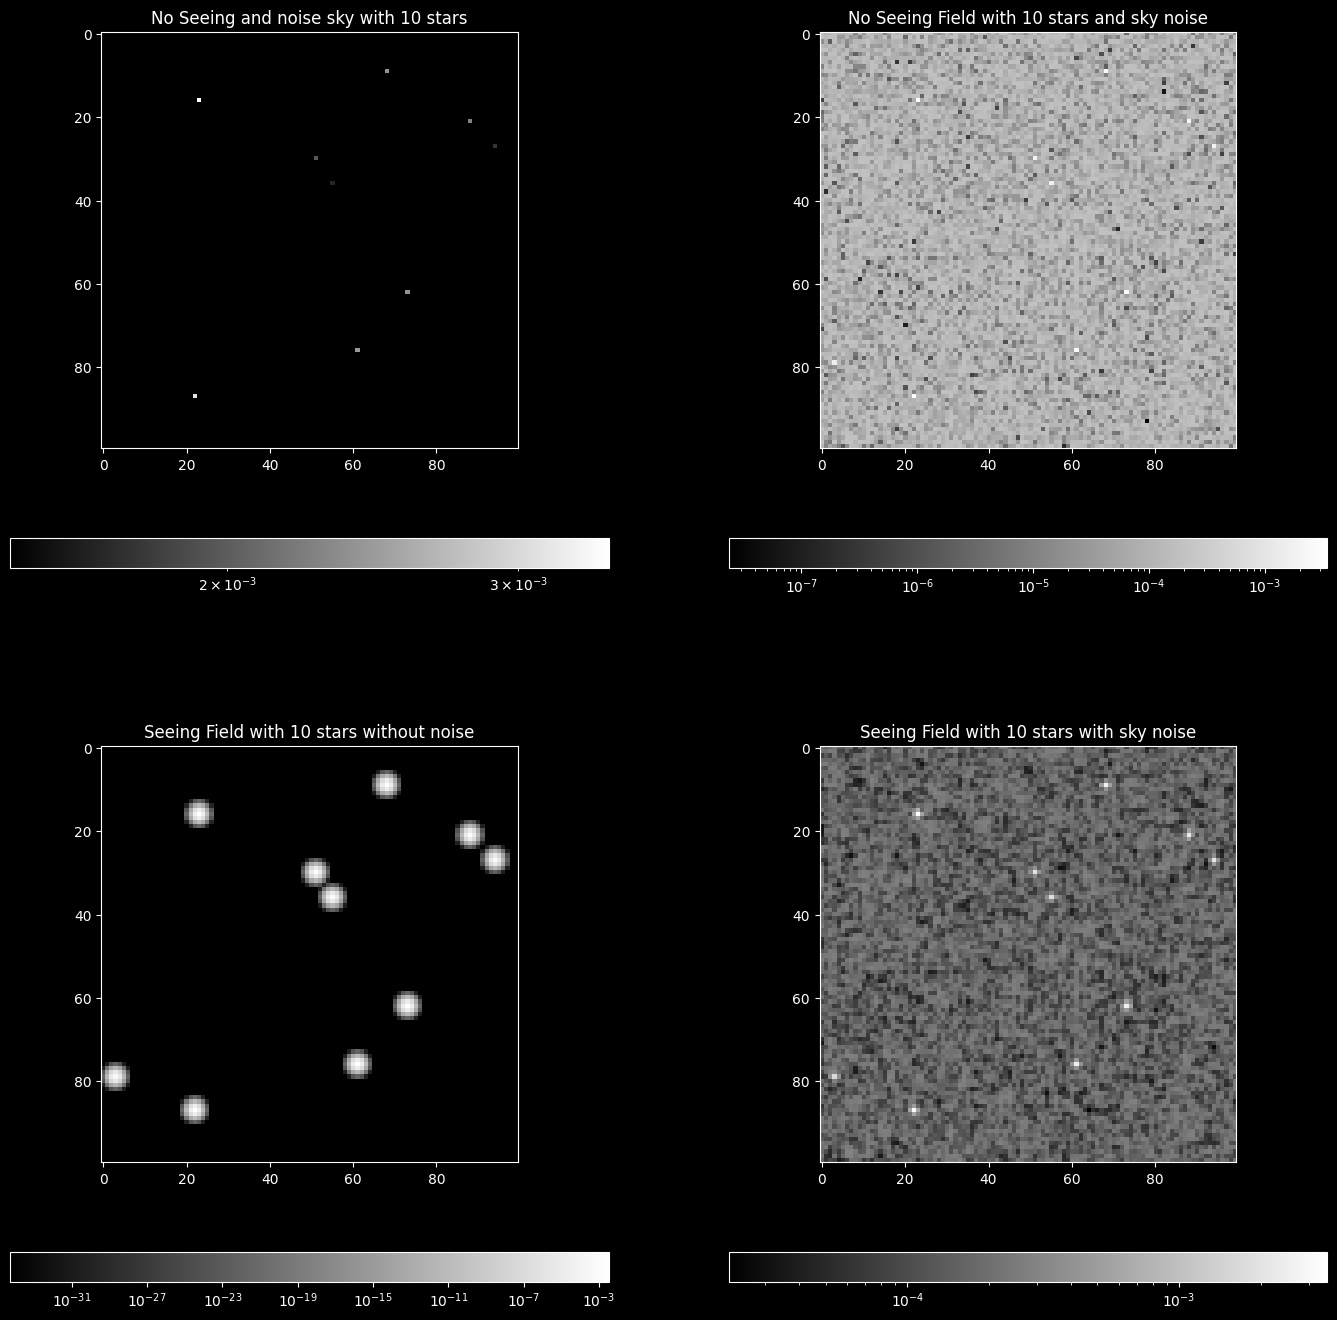

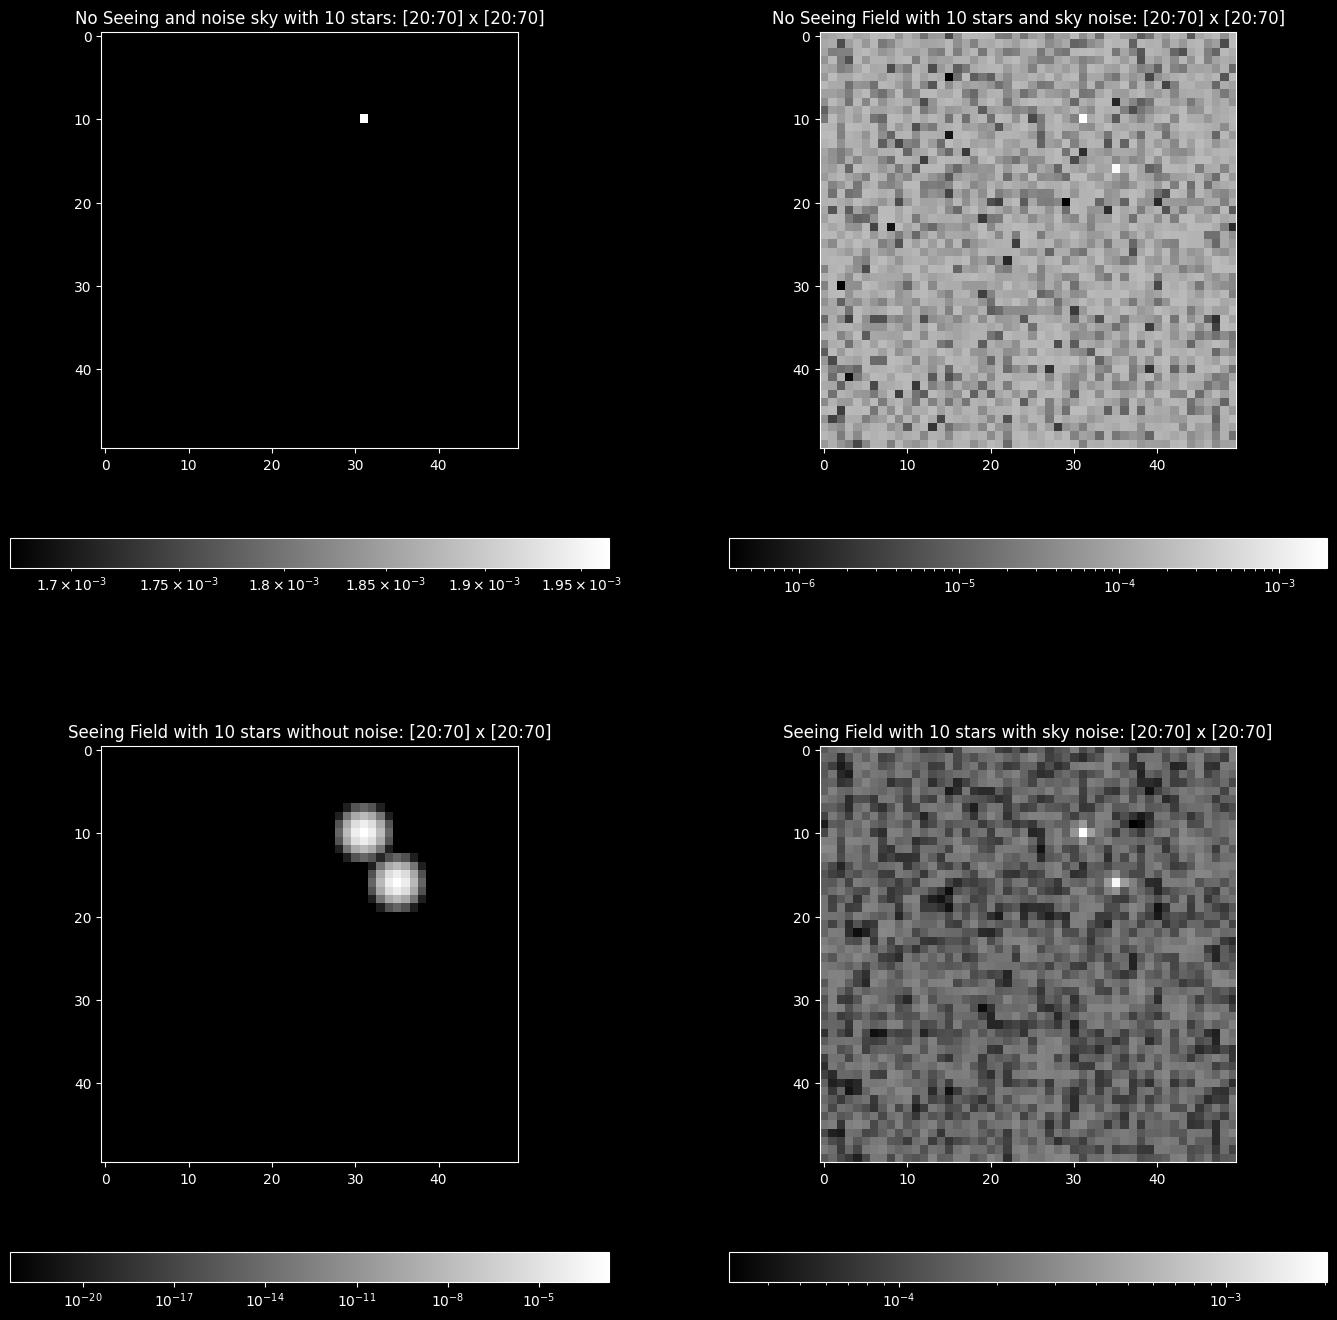

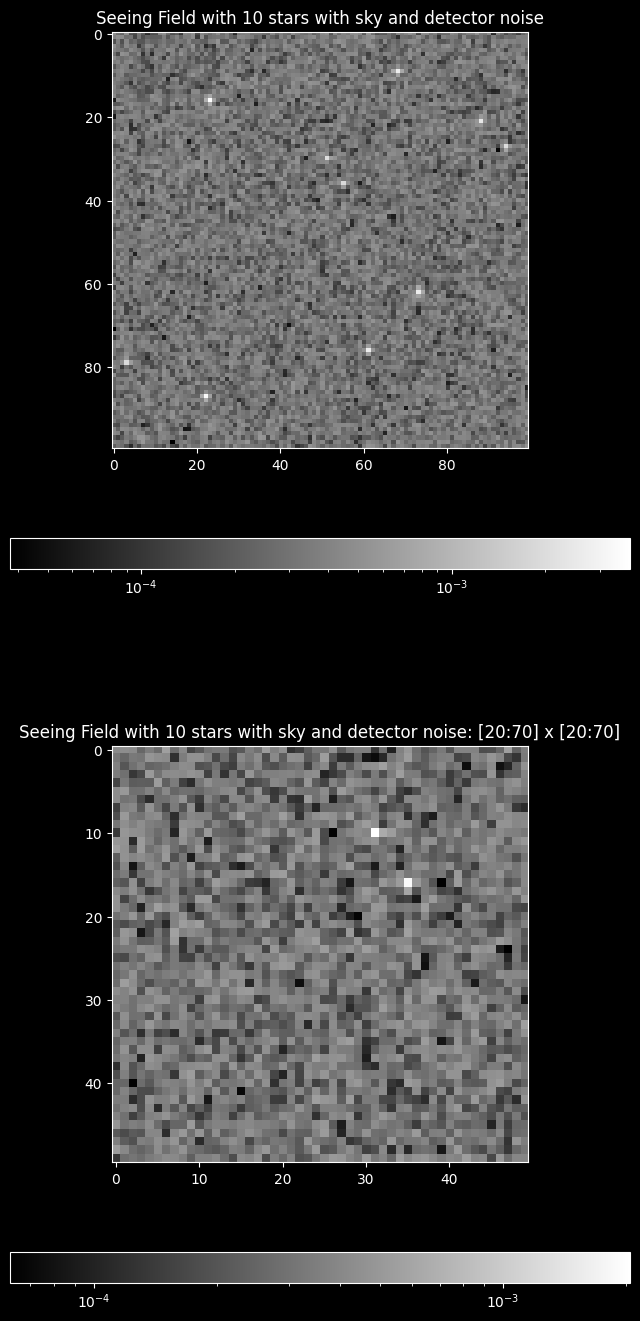

In [7]:
# SEVENTH CELL



##* 
def noise(n: float = 2e-4, dim: int = N) -> np.ndarray:
    """Noise generator
    It generates a (dim,dim) matrix of noise, using
    an arbitrary intensity n times
    a random value in [0,1]

    :param n: max intensity of noise, defaults to 2e-4
    :type n: float, optional
    :param dim: size of the field, defaults to N
    :type dim: int, optional

    :return: noise matrix
    :rtype: np.ndarray
    """
    np.random.seed()
    # random multiplicative (dim,dim) matrix
    N0 = np.random.random((dim, dim))*n
    return check_field(N0)


# generation of the field and the stars
F, S = initialize()


# add background noise
F_n = F + noise()


## Plot
fig1, ((img_field, img_field_noise),(img_field_seeing,img_field_snoise)) = plt.subplots(2,2,figsize=(17,17))
fig2, ((img_zoom, img_zoom_noise)  ,(img_zoom_seeing,img_zoom_snoise))   = plt.subplots(2,2,figsize=(17,17))
fig3, (img_field_tot, img_zoom_tot) = plt.subplots(2,1,figsize=(8,17))

#  0 : positive image
# -1 : negative image
v = 0

# detector noise
det_noise = 3e-4

field_image(fig1, img_field,F,v)
#img_field.imshow(1-F)
img_field.title.set_text(f'No Seeing and noise sky with {M} stars')
field_image(fig2, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.title.set_text(f'No Seeing and noise sky with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')


field_image(fig1, img_field_noise,F_n,v)
#img_field_noise.imshow(1-F_n)
img_field_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise')
field_image(fig2, img_zoom_noise,F_n,v,[inf,sup])
#img_zoom_noise.imshow(1-F_n[inf:sup,inf:sup,:])
img_zoom_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

# generate atmosferic seeing image without sky noise
F_s = atm_seeing(F)

field_image(fig1, img_field_seeing,F_s,v)
#img_field_seeing.imshow(1-F_s)
img_field_seeing.title.set_text(f'Seeing Field with {M} stars without noise')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
#img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars without noise: [{inf}:{sup}] x [{inf}:{sup}]')

# generate atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n)
field_image(fig1, img_field_snoise,F_sn,v)
#img_field_snoise.imshow(1-F_sn)
img_field_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise')
field_image(fig2, img_zoom_snoise,F_sn,v,[inf,sup])
#img_zoom_snoise.imshow(1-F_sn[inf:sup,inf:sup,:])
img_zoom_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

# add detector noise, set to 3e-4 (> than background one)
F_sn += noise(det_noise)
field_image(fig3, img_field_tot,F_sn,v)
#img_field_tot.imshow(1-F_sn)
img_field_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise')
field_image(fig3, img_zoom_tot,F_sn,v,[inf,sup])
#img_zoom_tot.imshow(1-F_sn[inf:sup,inf:sup,:])
img_zoom_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise: [{inf}:{sup}] x [{inf}:{sup}]')

if sv == 1:
    fig1.savefig(os.path.join(picdir,'field_noise.png'))
    fig2.savefig(os.path.join(picdir,'zoom_noise.png'))
    fig3.savefig(os.path.join(picdir,'image.png'))

plt.show()


## II part: detect stars
### First cell

0.0 0.00016468653977771508


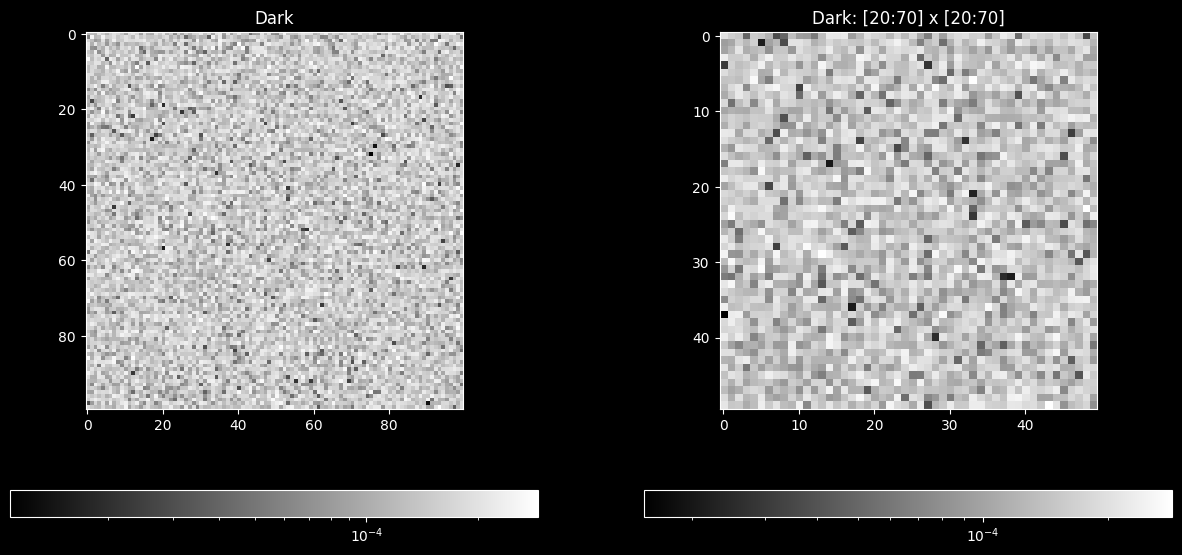

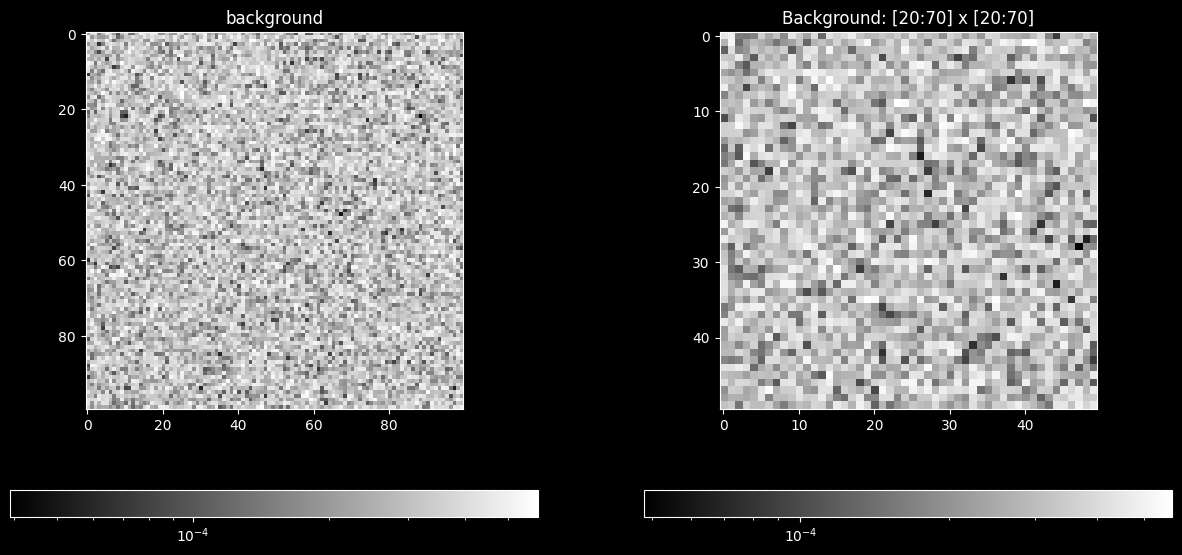

In [8]:
## First cell

# Dark

def dark_elaboration(n_value: float = 3e-4, iteration: int = 3) -> np.ndarray:
    """The function computes a number `iteration` of dark and means over them

    :param n_value: noise value, defaults to 3e-4
    :type n_value: float, optional
    :param iteration: number of dark to compute, defaults to 3
    :type iteration: int, optional

    :return: mean dark
    :rtype: np.ndarray
    """
    dark = noise(n_value)
    for i in range(iteration-1):
        dark += noise(n_value)
    dark /= iteration
    return dark

dark = dark_elaboration()

mean_dist = np.array([[abs(dark[i,j]-dark[0,0]) for i in range(len(dark))] for j in range(len(dark))])

print(min(mean_dist[0,:]),max(mean_dist[0,:]))

# Background
bg  = atm_seeing(noise())
bg += noise(3e-4)

#bg-=dark

## Plot
fig1, (dark_img, dark_zoom) = plt.subplots(1,2,figsize=(15,7))
fig2, (bg_img, bg_zoom) = plt.subplots(1,2,figsize=(15,7))

#  0 : positive image
# -1 : negative image
v = 0

dark_img.set_title('Dark')
field_image(fig1, dark_img,dark,v)
#dark_img.imshow(dark)
dark_zoom.set_title(f'Dark: [{inf}:{sup}] x [{inf}:{sup}]')
field_image(fig1, dark_zoom,dark,v,[inf,sup])
#dark_zoom.imshow(dark[inf:sup,inf:sup,:])
bg_img.set_title('background')
field_image(fig2, bg_img,bg,v)
#bg_img.imshow(bg)
bg_zoom.set_title(f'Background: [{inf}:{sup}] x [{inf}:{sup}]')
field_image(fig2, bg_zoom,bg,v,[inf,sup])
#bg_zoom.imshow(bg[inf:sup,inf:sup,:])

plt.show()    

Consider the field with the seeing only. I want to recostruct the psf.

First, I locate the most luminous star of the field and isolate it, extracting the point around it. From this matrix I apply the algorith of Lucy to get the psf

**To do:**
1. **How to treat the presence of near objects**
2. **How to treat the limits of the field**
     - Maybe it is better rejecting those objects (?)

302


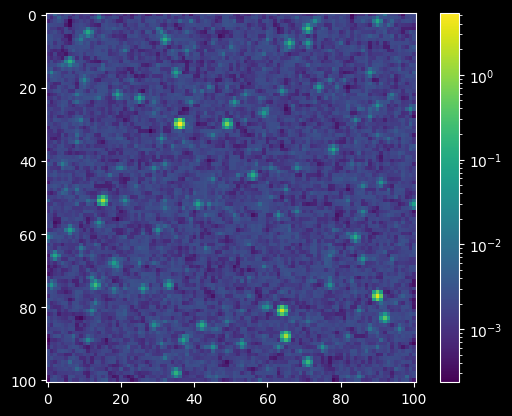

In [35]:
# from scipy.signal import argrelextrema

M = 500

# generation of the field and the stars
F, S = initialize(sdim=M)

# taking the 0.2% of the luminosity of a 1 solar mass star
# for 1 solar mass star L = M**beta = 1 in solar luminosity unit 
n = 0.2/1e2

objs = S.lum
objs = np.where(objs > n)[0]
objs = len(objs)
print(objs)

# add background noise
F_n = F + noise(n)

# detector noise
det_noise = 3e-4

# generate atmosferic seeing image without sky noise
F_s = atm_seeing(F, sigma=0.5)

# generate atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n, sigma=0.5)

plt.imshow(F_sn, norm='log')
plt.colorbar()
plt.show()

5.390537806752876
5.3913189704637094
dark =	0.0002898832781769495
max = 5.3913189704637094
noise =	0.0031849998799867475
stn =	0.06 %
max = 3.4151659903635596
noise =	0.0031849998799867475
stn =	0.09 %
max = 2.817733680392907
noise =	0.0031849998799867475
stn =	0.11 %
max = 1.6597262467442264
noise =	0.0031849998799867475
stn =	0.19 %
max = 1.4541867167151825
noise =	0.0031849998799867475
stn =	0.22 %
max = 0.6806937135676984
noise =	0.0031849998799867475
stn =	0.47 %
max = 0.3998846112975659
noise =	0.0031849998799867475
stn =	0.80 %
max = 0.26682988349659664
noise =	0.0031849998799867475
stn =	1.19 %
max = 0.23946793316631015
noise =	0.0031849998799867475
stn =	1.33 %
max = 0.19133388287114092
noise =	0.0031849998799867475
stn =	1.66 %
max = 0.1685587812821956
noise =	0.0031849998799867475
stn =	1.89 %
max = 0.1564391999738033
noise =	0.0031849998799867475
stn =	2.04 %
max = 0.14305472969705912
noise =	0.002
stn =	1.40 %
max = 0.13390953682665505
noise =	0.002
stn =	1.49 %
max = 0.12

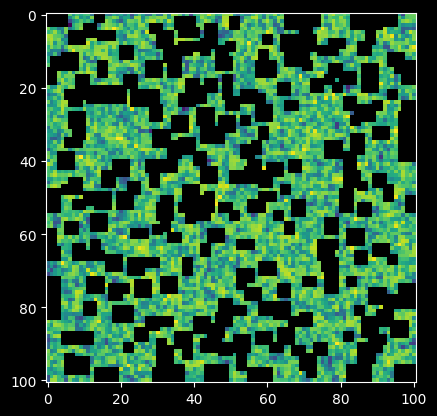


The star number is
Ext	True
245	500
Expected: 302
Precision: 81.13 %


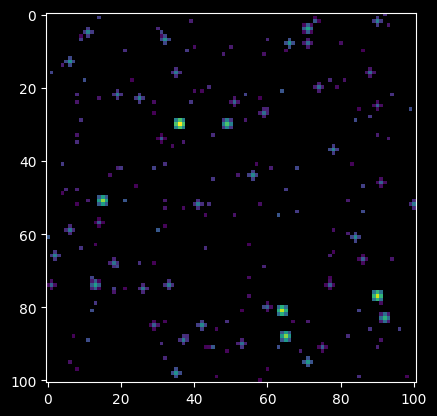

In [36]:
# add detector noise, set to 3e-4 (> than background one)
F_sn += noise(det_noise)

##* Detection
""" 
    For the recostruction of psf it's usefull only one star, 
    for exemple the most luminous one.
"""
#test_field = np.zeros((N,N))
test_field = F_sn.copy()
# find the maximum value coordinates
max_ind = np.unravel_index(np.argmax(test_field, axis=None), test_field.shape)

m_x, m_y = max_ind

print(max(S.lum))
print(test_field[max_ind])



def grad_check(field: np.ndarray, index: tuple[int,int], size: int = 3) -> tuple[np.ndarray,np.ndarray]:
    """Function explores the neighbourhood of a selected object and gives its size.
    It studies the gradient around the obj in the four cardinal directions and the diagonal ones.
    It takes in account also the presence of the edges of the field.
    If no other obj is found in a whichever direction, that one is stored and returned.

    :param field: the field matrix
    :type field: np.ndarray
    :param index: the obj coordinates
    :type index: tuple[int,int]
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional
    
    :return: a tuple with:
             * a_size : array with the size of the obj in each directions, like [x_up, x_down, y_up, y_down]
             * ind_neg : indeces in `a_size` for free directions
    :rtype: tuple[np.ndarray,np.ndarray]
    """    
    # field size
    dim = len(field)
    # object position
    x, y = index
    # treatment for edges; f stays for forward, b for backward
    xlim_f, ylim_f = min(size, dim-2-x), min(size, dim-2-y)
    xlim_b, ylim_b = min(size, x+1), min(size, y+1)
    # limits for the object
    xsize_f0, xsize_b0 = min(size, dim-1-x), min(size, x)
    ysize_f0, ysize_b0 = min(size, dim-1-y), min(size, y)
    # saving them in an array
    # the negative sign is used to take trace of free direction
    a_size0 = np.array([xsize_f0,xsize_b0,ysize_f0,ysize_b0], dtype=int) * -1
    # creating an array to store the size of the object in differt directions
    a_size = np.copy(a_size0)
    # moving in the four directions
    for i_f, i_b, j_f, j_b in zip(range(xlim_f), range(xlim_b), range(ylim_f), range(ylim_b)):
        # studying the sign of the gradient
        a_size[0] = i_f if (field[x+i_f+1, y]-field[x+i_f, y] >= 0 and a_size[0] == a_size0[0]) else a_size[0]
        a_size[1] = i_b if (field[x-i_b-1, y]-field[x-i_b, y] >= 0 and a_size[1] == a_size0[1]) else a_size[1]
        a_size[2] = j_f if (field[x, y+j_f+1]-field[x, y+j_f] >= 0 and a_size[2] == a_size0[2]) else a_size[2]
        a_size[3] = j_b if (field[x, y-j_b-1]-field[x, y-j_b] >= 0 and a_size[3] == a_size0[3]) else a_size[3]
        # diagonal
        a_size[0], a_size[2] = (i_f, j_f) if (field[x+i_f+1, y+j_f+1]-field[x+i_f, y+j_f] >= 0 and a_size[0] == a_size0[0] and a_size[2] == a_size0[2]) else  (a_size[0], a_size[2])
        a_size[0], a_size[3] = (i_f, j_b) if (field[x+i_f+1, y-j_b-1]-field[x+i_f, y-j_b] >= 0 and a_size[0] == a_size0[0] and a_size[3] == a_size0[3]) else  (a_size[0], a_size[3])
        a_size[1], a_size[2] = (i_b, j_f) if (field[x-i_b-1, y+j_f+1]-field[x-i_b, y+j_f] >= 0 and a_size[1] == a_size0[1] and a_size[2] == a_size0[2]) else  (a_size[1], a_size[2])
        a_size[1], a_size[3] = (i_b, j_b) if (field[x-i_b-1, y-j_b-1]-field[x-i_b, y-j_b] >= 0 and a_size[1] == a_size0[1] and a_size[3] == a_size0[3]) else  (a_size[1], a_size[3])
        # when for every direction there's an obj, the for cycle stops 
        if (True in (a_size == a_size0)) == False: break
    # looking for free direction
    condition = np.where(a_size < 0)[0]
    # if there is at least one
    if len(condition) != 0:
        # saving the indices
        ind_neg = condition
        # removing the sign
        a_size[ind_neg] *= -1
    # if there is none
    else:
        # storing the information
        ind_neg = np.array([-1])
    return a_size, ind_neg

"""
#!!  COSE DA AGGIUSTARE
#!   1. capire come aggiustare la situazione quando 2 oggetti sono appiccicati
#!   2. capire come tenere di conto del bordo
""" 
def approx_width(field: np.ndarray, index: tuple[int,int], thr: float = 1e-10, size: int = 3) -> tuple:
    """Extimation of the size of the object
    The function takes in input the most luminous point, calls the `grad_check()` function
    to investigate the presence of other objects and then to extimate the size of the
    target conditionated by the choosen threshold value.

    :param field: field matrix
    :type field: np.ndarray
    :param index: coordinates of the most luminous point
    :type index: tuple
    :param thr: threshold to get the size of the element, defaults to 1e-10
    :type thr: float
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional

    :return: a tuple with the size in each directions
    :rtype: tuple
    """
    # coordinates of the object
    x, y = index
    # saving the value in that position
    max_val = field[index]
    # getting the size of the object
    limits, ind_limits = grad_check(field,index,size)
    # condition for at least one free direction
    if ind_limits[0] != -1:
        # taking the maximum size in free direction group
        pos = max(limits[ind_limits])
        # storing the index for that direction
        ind_pos = np.where(limits == pos)[0][0]
    else:
        # taking the maximum size 
        ind_pos = int(np.argmax(limits))
        # storing its index
        pos = limits[ind_pos]
    # creating the parameter for the comparison
    ratio = 1
    # inizializing the index to explore the field
    i = 0
    # moving along x direction
    if ind_pos < 2:
        # direction for the exploration
        sign = (-2*ind_pos + 1)
        # take pixels until the threshold or the adge 
        while(ratio > thr and i < pos):
            i += 1
            # upload the parameter     
            ratio = field[x+sign*i,y]/max_val
    # moving along y direction
    else:
        # direction for the exploration
        sign = (-2*ind_pos + 5)
        # take pixels until the threshold 
        # take pixels until the threshold or the adge 
        while(ratio > thr and i < pos):
            i += 1     
            # upload the parameter     
            ratio = field[x,y+sign*i]/max_val
    # saving extimated width
    width = i
    # taking the min between width and size
    return tuple(min(width,i) for i in limits)

def object_isolation(obj: tuple[int,int], field: np.ndarray, coord: list[tuple], thr: float = 1e-10, size: int = 3) -> np.ndarray:
    """To isolate the most luminous star object.
    The function calls the `approx_width()` function 
    to extract from the field the object of interest.

    :param field: field matrix
    :type field: np.ndarray
    :param thr: threshold for `approx_width()` function, defaults to 1e-10
    :type thr: float, optional
    :param dim: size of the field, defaults to `N`
    :type dim: int, optional
    
    :return: the object matrix
    :rtype: np.ndarray
    """
    # calculating the size of the object
    wx_u, wx_d, wy_u, wy_d = approx_width(field, obj, thr=thr, size=size)
    # extracting the coordinates
    x, y = obj
    # printing infos
    # print(f'star ({x},{y}) val {field[obj]} -> {wx_u}, {wx_d}, {wy_u}, {wy_d}')
    # isolating the obj and coping in order to preserve the field matrix
    extraction = field[x - wx_d : x + wx_u +1, y - wy_d : y + wy_u +1].copy()
    # removing the object from the field
    field[x - wx_d : x + wx_u +1, y - wy_d : y + wy_u +1] = 0.0
    # removing the obj from the available points 
    for k in [(x+i, y+j) for i in range(-wx_d,wx_u+1) for j in range(-wy_d, wy_u+1)]:
        # control condition
        if k in coord: coord.remove(k)
    # #! DA RIMUOVERE PRIMA DI MANDARE !#
    # if M < 11:
    #     plt.imshow(extraction, norm='log')
    #     plt.colorbar()
    #     plt.show()
    #     plt.imshow(field, norm='log')   
    #     plt.colorbar()
    #     plt.show()
    # #!                               !#
    return extraction

##*
def evaluate_noise(field: np.ndarray, coord: list[tuple], point_num: int = 100, loop_num: int = 4) -> float:
    """To estimate the background noise value.
    The function draws points in the field and averages over them in order to get an estimation of the mean luminosity

    :param field: field matrix
    :type field: np.ndarray
    :param coord: list of possible position in the field
    :type coord: list[tuple]
    :param point_num: number of points to draw, defaults to 100
    :type point_num: int, optional
    :param loop_num: number of loops over which one want to average, defaults to 4
    :type loop_num: int, optional
    :return: the estimated noise value
    :rtype: float
    """
    # defining the variable for the estimated noise
    est_noise = 0
    # saving the size of coord
    dim = len(coord)
    # the number of points depends on the number of remained points in the field
    n_point = min(point_num, dim)
    # making `loop_num` drawing over which average
    for i in range(loop_num):
        # drawing positions in the coordinates list
        ind = np.random.choice(dim, size=n_point, replace=False)
        # making an array for the drawn elements
        element = np.array([field[coord[i]] for i in ind])
        # evaluating the mean
        est_noise += sum(element)/len(element)
    # averaging
    est_noise /= loop_num
    return est_noise

##*
def counting_stars(field: np.ndarray, dark_noise: float, thr: float = 1e-3, size: int = 3, coord: list[tuple] = [], point_num: int = 100, loop_num: int = 4) -> list[np.ndarray]:
    """Extracting stars from field
    The function calls the `object_isolation()` function iteratively until
    the signal-to-noise ratio (`s_t_n`) is less than 2

    :param field: field matrix
    :type field: np.ndarray
    :param dark_max: threshold for consider a signal
    :type dark_max: float
    :param thr: threshold for the size of an obj, defaults to 1e-3
    :type thr: float, optional
    :param size: max size of an obj, defaults to 3
    :type size: int, optional

    :return: the list of extracted object. Its len() is the number of found obj
    :rtype: list[np.ndarray]
    """
    # coping the field to preserve it
    tmp_field = field.copy()
    # saving size of the field
    dim = len(tmp_field)
    # creating an empty list to store the extracted objects
    a_extraction = []
    # evaluating the maximum in the field
    max_pos = np.unravel_index(np.argmax(tmp_field, axis=None), tmp_field.shape)
    max_val = tmp_field[max_pos]
    # printing it
    print(f'max = {max_val}')
    # generating list with all possible position, if it was not 
    if len(coord) == 0:  
        coord = [(i,j) for i in range(dim) for j in range(dim)]
    # Before the search of objects, let's set an initial value for the noise, 
    #   that will set the condition to start the estimation of the signal-to-noise ratio
    # first noise value
    n0 = evaluate_noise(tmp_field, coord, point_num=100, loop_num=loop_num)
    # averaging with the noise from dark
    n0 = (n0 + dark_noise) / 2
    # taking the minimum between n and the 10% of maximum luminosity
    n0 = min(n0, max_val/10)
    print(f'noise =\t{n0}')
    #! for me to control
    i = 0
    # evaluating the signal-to-noise ratio
    s_t_n = max_val / n0
    print(f'stn =\t{1/s_t_n*100:.2f} %')
    # starting the loop 
    while s_t_n > 2 and i < M:
        # appending the new extracted object to the list
        a_extraction += [object_isolation(max_pos, tmp_field, coord, thr, size)]
        # evalueting the new maximum in the field
        max_pos = np.unravel_index(np.argmax(tmp_field, axis=None), tmp_field.shape)
        max_val = tmp_field[max_pos]
        print(f'max = {max_val}')
        # condition to start the noise evaluation
        if s_t_n <= 50:
            n0 = evaluate_noise(field,coord,point_num,loop_num)
            # taking the max between n and noise from dark
            n0 = max(n, dark_noise)
        print(f'noise =\t{n0}')
        s_t_n = max_val/n0
        print(f'stn =\t{1/s_t_n*100:.2f} %')
        i += 1
        if i == M: print('!WARNING!: ITERATION EXCEDED!')
    plt.imshow(tmp_field, norm='log')
    plt.show()
    return a_extraction

# mean dark
dark = dark_elaboration(det_noise)
# for the noise estimated from dark take the maximum
d = dark[np.unravel_index(np.argmax(dark), dark.shape)]
print(f'dark =\t{d}')

# number of points
p_num = 200 
# thr to define an obj
thr = 1e-1
a_extraction = counting_stars(test_field, d, thr=thr, size=3, point_num=p_num)
print(f'\nThe star number is\nExt\tTrue\n{len(a_extraction)}\t{M}')
print(f'Expected: {objs}')
print(f'Precision: {len(a_extraction)/objs*100:.2f} %')

# extraction = a_extraction[0]

selected = a_extraction[-1]
thr_tmp = selected[np.unravel_index(np.argmax(selected), selected.shape)]



plt.imshow(np.where(F_s>thr_tmp, F_s, 0.0), norm='log')
# plt.imshow(F_s, norm='log')
plt.show()


[0.001, 0.003, 0.001, 0.003]
0.002 0.0002935899356971261
-----------
Found	Wanted	Expected
123	171	671
Count: 123
Miscount: 0
----
f/w =	72 %
f/e =	18 %
f/tot =	11 %
Accuracy: 100.00 %
----
pm0 = 0.002211	Drawing
pm1 = 0.000386	Averaging
pmf = 0.000227	Min


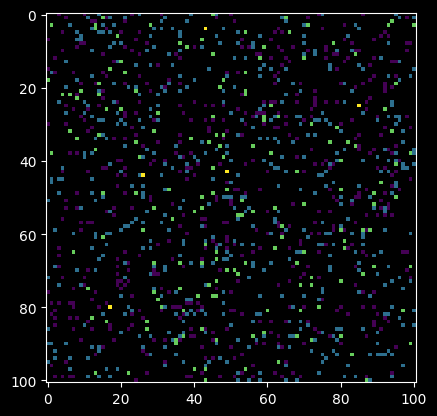

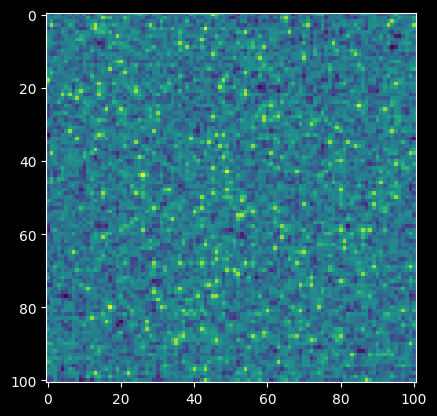

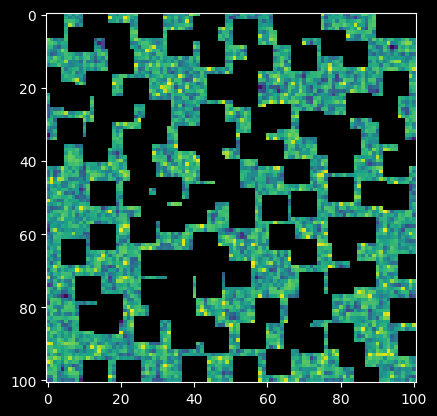

In [11]:
test_field = np.zeros((N,N))
number = 500
lum = [1e-3,n+1e-3]*number +  [n*5] * (number//3) + [n*10]*5
print(lum[:4])
org_pos = []
pos = (randint(0,N),randint(0,N))
for l in lum:
    while test_field[pos] != 0:
        pos = (randint(0,N),randint(0,N))
    test_field[pos] = l
    org_pos += [pos]
noise_camp = atm_seeing(noise(n) + test_field) + noise(det_noise)

d = dark_elaboration(det_noise)
d = d[np.unravel_index(np.argmax(d), d.shape)]
print(n,d)


#noise_camp = noise_camp - d

plt.figure(1)
plt.imshow(test_field, norm='log')

plt.figure(2)
plt.imshow(noise_camp, norm='log')

# making a list with every position in the field, format (x,y)
grid = [(i,j) for i in range(N) for j in range(N)]
# creating an empty array to collect the maximum values
maxvalues = np.array([])
# setting the number of points taken around
size_num = 100
# setting the number of iteration for the drawing
cnt = 4
# noise
pm_noise = 0
for ii in range(cnt):
    # drawing positions in the grid
    ind = np.random.choice(len(grid), size=size_num, replace=False)
    # making an array for the drawn elements
    element = np.array([noise_camp[grid[i]] for i in ind])
    mean = sum(element)/len(element)
    # evaluating the mean
    pm_noise += mean
# averaging
pm_noise /= cnt
ss = f'pm0 = {pm_noise:.6f}\tDrawing'
pm_noise = (3*d + pm_noise)/8
ss2 = f'pm1 = {pm_noise:.6f}\tAveraging'
pm_noise = min(pm_noise, noise_camp[np.unravel_index(np.argmax(noise_camp),noise_camp.shape)]/100)
# setting the number of points taken around
size_num = 700
# setting the noise thr to d of the detector
thr = d
# setting the starting max value
maxval = 1
# initializing the iteration counter
it = 0
# good counter
pos_cnt = 0
# starting the loop
while maxval/thr > 5 and it < len(lum)+5:
    # print(f'iteration {it}')
    # finding the maximum
    maxind = np.unravel_index(np.argmax(noise_camp), noise_camp.shape)
    maxval = noise_camp[maxind]
    xm, ym = maxind
    if maxval == 0:
        print('!WARNING: MAXVAL == 0!')
        break
    if maxind in org_pos:
        pos_cnt += 1
    # removing the obj
    edges = [min(3,xm), min(4,N-xm), min(3,ym), min(4,N-ym)]
    noise_camp[xm-edges[0]:xm+edges[1], ym-edges[2]:ym+edges[3]] = 0.0
    # saving the maxval
    maxvalues = np.append(maxvalues,maxval)
    # print(f'max =\t{maxval}')
    # print(f'pos =\t{maxind}')
    # removing the maxval obj from the grid
    for k in [(xm-3+i,ym-3+j) for i in range(7) for j in range(7)]:
        # removing only coordinates which aren't have been removed yet
        if k in grid:
            grid.remove(k)
    # saving the actual dim of grid
    dim = len(grid)
    # the number of points depends on the number of remained points in the field
    n_point = min(size_num, dim)
    if maxval/pm_noise<=50:
        # defining the variable to mean the noise
        reco_n_bg = 0
        hold = []
        for ii in range(cnt):
            # drawing positions in the grid
            ind = np.random.choice(dim, size=n_point, replace=False)
            # making an array for the drawn elements
            element = np.array([noise_camp[grid[i]] for i in ind])
            mean = sum(element)/len(element)
            # evaluating the mean
            reco_n_bg += mean
            hold += [mean]
        # averaging
        reco_n_bg /= cnt
        # print(f'noise =\t{reco_n_bg}')
        # print(f'great =\t{max(hold)}')
        # controlling the value of noise
        thr = max(reco_n_bg, d)
        # print(f'thr =\t{thr}')
        # print(f's:n =\t{maxval/thr}')
        # print(f's:n2 =\t{maxval/max(hold)}')
    it += 1
    if it == len(lum)+1: print(f'MAX ITERATION NUMBER EXCEDED! -> {it}')

found = len(maxvalues)
wanted = number//3 + 5
expected = wanted + number        
print('-----------'+ f'\nFound\tWanted\tExpected\n{found}\t{wanted}\t{expected}')
print(f'Count: {pos_cnt}\nMiscount: {found-pos_cnt}')
print(f'----\nf/w =\t{found/wanted*100:.0f} %\nf/e =\t{found/expected*100:.0f} %\nf/tot =\t{found/(wanted+number*2)*100 :.0f} %')
if pos_cnt != found: print(f'c/w =\t{pos_cnt/wanted*100:.0f} %\nc/e =\t{pos_cnt/expected*100:.0f} %\nc/tot =\t{pos_cnt/(wanted+number*2)*100 :.0f} %')
print(f'Accuracy: {pos_cnt/found*100:.2f} %\n----')
plt.figure(3)
plt.imshow(noise_camp, norm='log')
# plt.colorbar()
print(ss)
print(ss2)
print(f'pmf = {pm_noise:.6f}\tMin')

# print(listpos)
# print(reco_n_bg)


plt.show()

0.00014919225306472247


NameError: name 'max_dark' is not defined

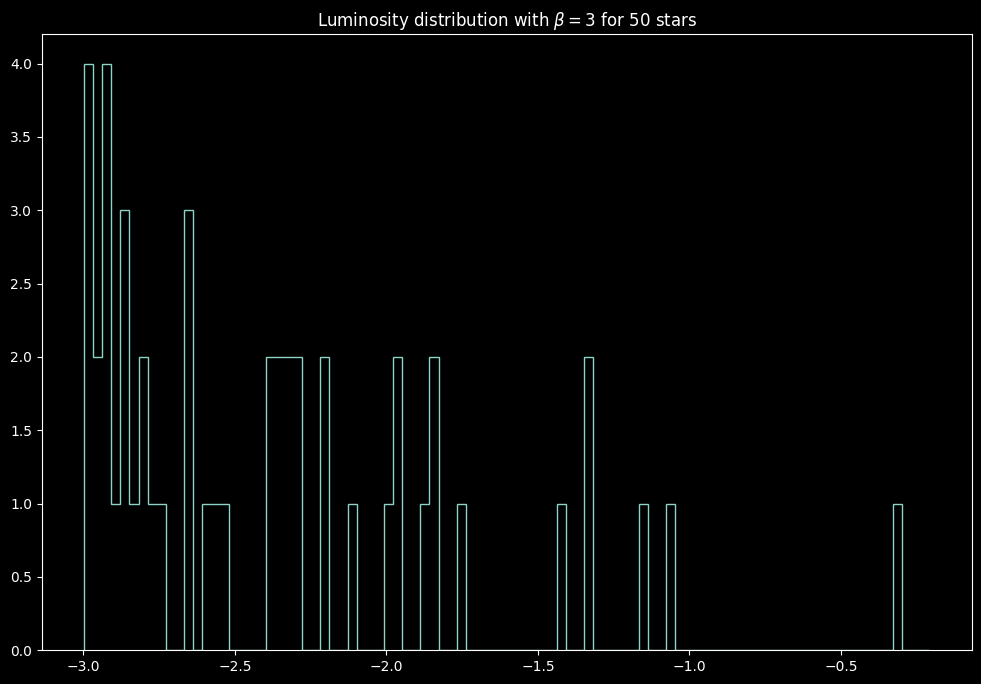

In [12]:
L_r = np.array([])
for element in a_extraction:
    L_r = np.append(L_r, element[np.unravel_index(np.argmax(element), element.shape)])

dark = dark_elaboration(det_noise)
L_r -= dark.sum()/(len(dark)**2)
print(dark.sum()/(len(dark)**2))

plt.figure(figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
bins = np.arange(min(np.log10(S.lum).min(),np.log10(L_r).min()), max(np.log10(S.lum).max(), np.log10(L_r).max()), 0.03)
# print(bins)
plt.hist(np.log10(S.lum),bins=bins,histtype='step', label='True')
plt.hist(np.log10(L_r-max_dark), bins=bins, histtype='step', label='Recostructed')
#plt.xticks(np.arange(-3.1,1.16,0.5))
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')
plt.legend()
plt.grid(linestyle='--', alpha=0.2)
plt.show()

### Lucy recostrucion



In [ ]:
n = len(extraction)
H = extraction
See = extraction[1:-1,1:-1]
W = np.array([])
print(See)
# I = J = K = L = n
# a = max(1, m-K+1)     b = min(m, I)
# c = max(1, l-L+1)     d = min(l, J)
# e = i+K-1             f = j+L-1
#
# W_ij,0 = sum_{m=i}^e sum_{l=j}^f ( H_ml * S_m-i+1,l-j+1 ) / ( sum_{p=a}^b sum_{q=c}^d S_m-p+1,l-q+1 ) 
n -= 2
summing = lambda i,j : sum( sum( H[m][l] * See[m-i][l-j] / sum( sum( See[m-p][l-q] for q in range(max(0,l-n+1), min(l+1,n-1)) ) for p in range(max(0, m-n+1), min(m+1,n-1)) ) for l in range(j, j+n-1) ) for m in range(i, i+n-1) )
W0 = np.array([[ summing(i,j)  for j in range(n)] for i in range(n)])
# print([[[ [ sum( sum( See[m-p][l-q] for q in range(max(0,l-n+1), min(l+1,n-1)) ) for p in range(max(0, m-n+1), min(m+1,n-1)) ) for l in range(j, j+n-1) ] for m in range(i, i+n-1) ] for j in range(n)] for i in range(n)])

iter = 20

def W(r):
    if r==1:
        return np.array([[ summing(i,j)  for j in range(n)] for i in range(n)])
    else:
        Wr = W(r-1)
        return np.array([[ Wr[i,j] * sum( sum( H[m][l] * See[m-i][l-j] / sum( sum( Wr[p][q] * See[m-p][l-q] for q in range(max(0,l-n+1), min(l+1,n-1)) ) for p in range(max(0, m-n+1), min(m+1,n-1)) ) for l in range(j, j+n-1) ) for m in range(i, i+n-1) )  for j in range(n)] for i in range(n)])

plt.figure(1,figsize=[12,12])
for i in range(n):
    for j in range(n):
        plt.subplot(3,3,i*n+j+1)
        plt.plot([W(r+1)[i,j] for r in range(iter)], '.-', label=f'({i},{j})')
        plt.legend()
plt.figure(2)
plt.imshow(W(iter),norm='log')
plt.colorbar()

print(W(iter))

plt.show()
# np.append(W,)

NameError: name 'extraction' is not defined